# Making the Data usable for Keras/tensorflow

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
import tensorflow as tf
import scipy.misc as sp
from keras.layers import Input, Convolution2D, Dense, Activation, Flatten
from keras.layers import  MaxPooling2D, Dropout, LocallyConnected2D
from keras.models import Model, load_model
from keras.optimizers import SGD

Using TensorFlow backend.


In [2]:
#file path for images
file_path = 'images/'

In [3]:
#image names are 1 to 1584
images = [file_path + str(i)+'.jpg' for i in range(1,1585)]

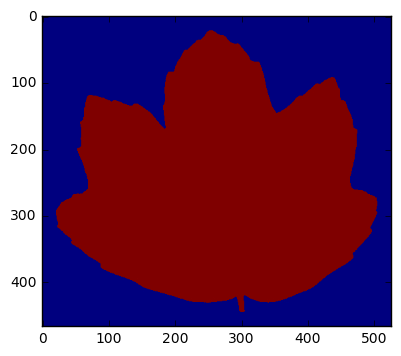

In [4]:
#seeing if pathway algo works.
img = mpimg.imread(images[0])
imgplot = plt.imshow(img)

In [5]:
#make dictionary of all images
image_dict = {}
for image in images:
    img = mpimg.imread(image)
    image_dict[image.split('.')[0].split('/')[1]] = [img.shape,img]

In [6]:
image_dict['344']

[(918, 924), array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)]

##### Seems that images have different aspect ratio and resolution... will need to clean this up

current solution is since there is alreay a lot of black space on the images, I will just increase the boarder 

### Add "black space" around each image to make all images the same size

In [7]:
#finding the max resoltuion in each image, so new images will be resized to maxium possible resolution
max_0 = 0
max_1 = 0
for key in image_dict:
    if image_dict[key][0][0] >= max_0:
        max_0 = image_dict[key][0][0]
    if image_dict[key][0][1] >= max_1:
        max_1 = image_dict[key][0][1]


In [9]:
shape = (max_1,max_1)
print shape

(1706, 1706)


In [9]:
# placing smaller image into new standardized image. standardized image is larger and adds extra black
# space around the image
for key in image_dict:
    large_array = np.zeros(shape)
    small_array = image_dict[key][1]
    lower_bound_0 = (large_array.shape[0] - small_array.shape[0])/2
    upper_bound_0 = ((large_array.shape[0] - small_array.shape[0])/2) + small_array.shape[0]
    lower_bound_1 = (large_array.shape[1] - small_array.shape[1])/2
    upper_bound_1 = ((large_array.shape[1] - small_array.shape[1])/2) + small_array.shape[1]
    large_array[lower_bound_0:upper_bound_0,lower_bound_1:upper_bound_1] = small_array
    image_dict[key].append(large_array)

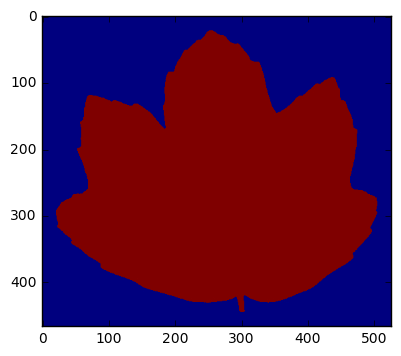

In [10]:
imgplot = plt.imshow(image_dict['1'][1])

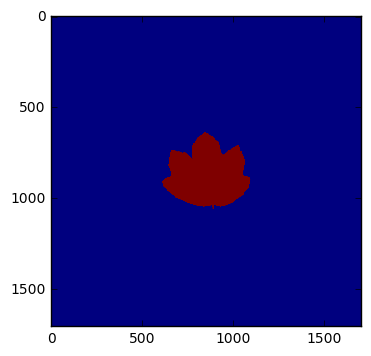

In [11]:
imgplot = plt.imshow(image_dict['1'][2])

### resizing the images

In [12]:
image_size = 64 # making a smaller square image

In [13]:
for key in image_dict:
    image_dict[key].append(sp.imresize(image_dict[key][2],(image_size,image_size)))

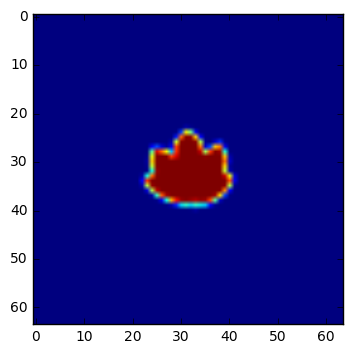

In [14]:
imgplot = plt.imshow(image_dict['1'][3])

# Split into training and test sets from kaggle list

In [15]:
train_df = pd.read_csv('train.csv')

In [16]:
train_df['id'].shape

(990,)

In [17]:
test_df = pd.read_csv('test.csv')

In [18]:
test_df.head()

id   margin1   margin2   margin3   margin4   margin5   margin6   margin7  \
0   4  0.019531  0.009766  0.078125  0.011719  0.003906  0.015625  0.005859   
1   7  0.007812  0.005859  0.064453  0.009766  0.003906  0.013672  0.007812   
2   9  0.000000  0.000000  0.001953  0.021484  0.041016  0.000000  0.023438   
3  12  0.000000  0.000000  0.009766  0.011719  0.017578  0.000000  0.003906   
4  13  0.001953  0.000000  0.015625  0.009766  0.039062  0.000000  0.009766   

   margin8   margin9    ...      texture55  texture56  texture57  texture58  \
0      0.0  0.005859    ...       0.006836   0.000000   0.015625   0.000977   
1      0.0  0.033203    ...       0.000000   0.000000   0.006836   0.001953   
2      0.0  0.011719    ...       0.128910   0.000000   0.000977   0.000000   
3      0.0  0.003906    ...       0.012695   0.015625   0.002930   0.036133   
4      0.0  0.005859    ...       0.000000   0.042969   0.016602   0.010742   

   texture59  texture60  texture61  texture62  texture63  texture64  
0   0.015625        0.0        0.0   0.000000   0.003906   0.053711  
1   0.013672        0.0        0.0   0.000977   0.037109   0.044922  
2   0.000000        0.0        0.0   0.015625   0.000000   0.000000  
3   0.013672        0.0        0.0   0.089844   0.000000   0.008789  
4   0.041016        0.0        0.0   0.007812   0.009766   0.007812  

[5 rows x 193 columns]

In [19]:
train_df.head(5)

id                species   margin1   margin2   margin3   margin4  \
0   1            Acer_Opalus  0.007812  0.023438  0.023438  0.003906   
1   2  Pterocarya_Stenoptera  0.005859  0.000000  0.031250  0.015625   
2   3   Quercus_Hartwissiana  0.005859  0.009766  0.019531  0.007812   
3   5        Tilia_Tomentosa  0.000000  0.003906  0.023438  0.005859   
4   6     Quercus_Variabilis  0.005859  0.003906  0.048828  0.009766   

    margin5   margin6   margin7  margin8    ...      texture55  texture56  \
0  0.011719  0.009766  0.027344      0.0    ...       0.007812   0.000000   
1  0.025391  0.001953  0.019531      0.0    ...       0.000977   0.000000   
2  0.003906  0.005859  0.068359      0.0    ...       0.154300   0.000000   
3  0.021484  0.019531  0.023438      0.0    ...       0.000000   0.000977   
4  0.013672  0.015625  0.005859      0.0    ...       0.096680   0.000000   

   texture57  texture58  texture59  texture60  texture61  texture62  \
0   0.002930   0.002930   0.035156        0.0        0.0   0.004883   
1   0.000000   0.000977   0.023438        0.0        0.0   0.000977   
2   0.005859   0.000977   0.007812        0.0        0.0   0.000000   
3   0.000000   0.000000   0.020508        0.0        0.0   0.017578   
4   0.021484   0.000000   0.000000        0.0        0.0   0.000000   

   texture63  texture64  
0   0.000000   0.025391  
1   0.039062   0.022461  
2   0.020508   0.002930  
3   0.000000   0.047852  
4   0.000000   0.031250  

[5 rows x 194 columns]

In [20]:
test_id = test_df.id.values

In [21]:
train_id = train_df.id.values

In [22]:
train_images = {}
train_labels = {}
test_images = {}

In [23]:
for key in image_dict:
    if int(key) in train_id:
        train_images[key] = image_dict[key][3]
        train_labels[key] = train_df['species'].loc[train_df['id'] == int(key)].values
    if int(key) in test_id:
        test_images[key] = image_dict[key][3]
        

In [24]:
# have to create a numeric key for each label, starting with 0
labels  = list(set(train_df['species']))
labels.sort(reverse=False)
labels_num_list = []
for i,l in enumerate(labels):
    labels_num_list.append(i)

In [25]:
labels_dict = {}
for i,l in enumerate(labels):
    labels_dict[l] = labels_num_list[i] 

In [26]:
train_labels_num_dict = {}

In [27]:
for key in train_labels:
    leaf_name = train_labels[key][0]
    train_labels_num_dict[key] = labels_dict[leaf_name]

# CNNs

In [28]:
input_layer = Input(shape=(image_size,image_size,1))

In [212]:
#first convolutional Layer
pipe = Convolution2D(8, 5, 5, border_mode='same')(input_layer)
pipe = (Activation('relu'))(pipe)
pipe = (MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))(pipe)
#pipe = Dense(100,activation='relu')(pipe)
#pipe = Dropout(.5)(pipe)

#second
pipe = (Convolution2D(16, 5, 5, border_mode='same'))(pipe)
pipe = (Activation('relu'))(pipe)
pipe = (MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))(pipe)
#pipe = Dense(100,activation='relu')(pipe)

#third
pipe = (Convolution2D(32, 5, 5, border_mode='same'))(pipe)
pipe = (Activation('relu'))(pipe)
pipe = (MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))(pipe)

#fourth
pipe = (Convolution2D(64, 5, 5, border_mode='same'))(pipe)
pipe = (Activation('relu'))(pipe)
pipe = (MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))(pipe)

#fifth 
pipe = (Convolution2D(128, 5, 5, border_mode='same'))(pipe)
pipe = (Activation('relu'))(pipe)
pipe = (MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))(pipe)

pipe = Dropout(.5)(pipe)


#Flatten
convolution_output = Flatten()(pipe)
#convolution_output = Dense(100, activation='relu')(convolution_output)
#convolution_output= Dropout(.5)(convolution_output)

output_layer = [Dense(99,activation='softmax')(convolution_output)]

In [213]:
sgd = SGD(lr=0.0001, momentum=0.9,decay=0.0,nesterov=False)

In [214]:
model = Model(input_layer,output_layer)

In [215]:
model.compile(optimizer=sgd,loss='categorical_crossentropy',
              metrics=['accuracy'])

In [216]:
image_size0 = max_0 #standardized
image_size1 = max_1 #standardized
num_channels = 1 #grey_scale
num_labels = len(labels_dict)

def reformat(dataset, labels):
  dataset = dataset.reshape(
    (-1, image_size, image_size, num_channels)).astype(np.float32)
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels

In [217]:
train_dataset,train_labels = reformat(np.array(train_images.values()),np.array(train_labels_num_dict.values()))

In [220]:
history = model.fit(train_dataset,train_labels,
                    batch_size = 792,
                    nb_epoch=1,
                    validation_split=0.20)

Train on 792 samples, validate on 198 samples
Epoch 1/1
792/792 [==============================] - 2s - loss: 4.5282 - acc: 0.0202 - val_loss: 4.6384 - val_acc: 0.0051


In [221]:
#history.model.save('CNN_leaf_3.h5')

In [222]:
history.model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 64, 64, 1)     0                                            
____________________________________________________________________________________________________
convolution2d_34 (Convolution2D) (None, 64, 64, 8)     208         input_1[0][0]                    
____________________________________________________________________________________________________
activation_34 (Activation)       (None, 64, 64, 8)     0           convolution2d_34[0][0]           
____________________________________________________________________________________________________
maxpooling2d_34 (MaxPooling2D)   (None, 32, 32, 8)     0           activation_34[0][0]              
___________________________________________________________________________________________

In [223]:
def reformat(dataset):
    dataset = dataset.reshape(
        (-1, image_size, image_size, num_channels)).astype(np.float32)
    return dataset


In [224]:
test_data = reformat(np.array(test_images.values()))

In [225]:
results = history.model.predict(test_data)

In [226]:
results_df = pd.DataFrame(results,columns = labels_dict.keys(),index=test_images.keys())

In [227]:
results_df = results_df.sort_index(axis=1)

In [228]:
results_df.head()

Acer_Capillipes  Acer_Circinatum  Acer_Mono  Acer_Opalus  Acer_Palmatum  \
818         0.010261         0.008475   0.010708     0.008559       0.011438   
819         0.006684         0.008829   0.008278     0.010025       0.011113   
346         0.011191         0.008178   0.011897     0.008357       0.008940   
347         0.007866         0.009331   0.010059     0.011954       0.010973   
343         0.010117         0.007148   0.007869     0.011182       0.009341   

     Acer_Pictum  Acer_Platanoids  Acer_Rubrum  Acer_Rufinerve  \
818     0.010487         0.009136     0.005963        0.009367   
819     0.011679         0.010671     0.009016        0.007853   
346     0.006657         0.013502     0.006194        0.008109   
347     0.011274         0.012190     0.010659        0.009496   
343     0.008411         0.009227     0.009106        0.010544   

     Acer_Saccharinum       ...         Salix_Fragilis  Salix_Intergra  \
818          0.015052       ...               0.013108        0.010832   
819          0.009072       ...               0.010006        0.011610   
346          0.013950       ...               0.010203        0.007768   
347          0.010310       ...               0.012336        0.008069   
343          0.013544       ...               0.012695        0.009883   

     Sorbus_Aria  Tilia_Oliveri  Tilia_Platyphyllos  Tilia_Tomentosa  \
818     0.009226       0.007644            0.007121         0.011234   
819     0.009878       0.011119            0.008578         0.010646   
346     0.007187       0.010963            0.008950         0.009997   
347     0.008001       0.010994            0.011798         0.009562   
343     0.010408       0.010740            0.007542         0.009280   

     Ulmus_Bergmanniana  Viburnum_Tinus  Viburnum_x_Rhytidophylloides  \
818            0.010236        0.012196                      0.009163   
819            0.009127        0.012553                      0.009783   
346            0.011996        0.011829                      0.009274   
347            0.011108        0.012699                      0.010698   
343            0.007973        0.016363                      0.007502   

     Zelkova_Serrata  
818         0.007499  
819         0.010621  
346         0.010460  
347         0.008331  
343         0.010704  

[5 rows x 99 columns]

In [229]:
results_df.index.name = 'ID'

In [230]:
results_df.head()

Acer_Capillipes  Acer_Circinatum  Acer_Mono  Acer_Opalus  Acer_Palmatum  \
ID                                                                             
818         0.010261         0.008475   0.010708     0.008559       0.011438   
819         0.006684         0.008829   0.008278     0.010025       0.011113   
346         0.011191         0.008178   0.011897     0.008357       0.008940   
347         0.007866         0.009331   0.010059     0.011954       0.010973   
343         0.010117         0.007148   0.007869     0.011182       0.009341   

     Acer_Pictum  Acer_Platanoids  Acer_Rubrum  Acer_Rufinerve  \
ID                                                               
818     0.010487         0.009136     0.005963        0.009367   
819     0.011679         0.010671     0.009016        0.007853   
346     0.006657         0.013502     0.006194        0.008109   
347     0.011274         0.012190     0.010659        0.009496   
343     0.008411         0.009227     0.009106        0.010544   

     Acer_Saccharinum       ...         Salix_Fragilis  Salix_Intergra  \
ID                          ...                                          
818          0.015052       ...               0.013108        0.010832   
819          0.009072       ...               0.010006        0.011610   
346          0.013950       ...               0.010203        0.007768   
347          0.010310       ...               0.012336        0.008069   
343          0.013544       ...               0.012695        0.009883   

     Sorbus_Aria  Tilia_Oliveri  Tilia_Platyphyllos  Tilia_Tomentosa  \
ID                                                                     
818     0.009226       0.007644            0.007121         0.011234   
819     0.009878       0.011119            0.008578         0.010646   
346     0.007187       0.010963            0.008950         0.009997   
347     0.008001       0.010994            0.011798         0.009562   
343     0.010408       0.010740            0.007542         0.009280   

     Ulmus_Bergmanniana  Viburnum_Tinus  Viburnum_x_Rhytidophylloides  \
ID                                                                      
818            0.010236        0.012196                      0.009163   
819            0.009127        0.012553                      0.009783   
346            0.011996        0.011829                      0.009274   
347            0.011108        0.012699                      0.010698   
343            0.007973        0.016363                      0.007502   

     Zelkova_Serrata  
ID                    
818         0.007499  
819         0.010621  
346         0.010460  
347         0.008331  
343         0.010704  

[5 rows x 99 columns]

In [231]:
results_df.set_index(results_df.index.astype(int),inplace=True)

In [232]:
results_df.sort_index(axis=0,ascending=True,inplace=True)

In [233]:
results_df.to_csv('submit.csv')